Created August 17, 2023

Purpose is to update location grid search in the following ways:
1. use templates whose constituent waveforms were normalized before stacking (fixes most false features)
2. use elep to find picktimes instead of envelope cross correlation
3. improved location search
4. compare locations to ComCat potential matches from the <a href="https://assets.pnsn.org/red/">redpy website</a> when possible

last updated November 29, 2023

In [1]:
import requests
import h5py
import yaml
import csv
import math
import eqcorrscan
from eqcorrscan import Tribe
from time import time
import obspy
from obspy import UTCDateTime, Trace
import pandas as pd
from glob import glob
import numpy as np
from obspy.signal.cross_correlation import *
import matplotlib.pyplot as plt
from geopy import distance
from tqdm import trange
from scipy import signal


import torch
plt.rcParams.update({'font.size': 10})
# from utils import *


import seisbench.models as sbm
device = torch.device("cpu")

from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
from mbf_elep_func import apply_mbf
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func
from ELEP.elep.trigger_func import picks_summary_simple

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter as MBF

Matched-filter CPU is not compiled! Should be here: /home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/fast_matched_filter/lib/matched_filter_CPU.so


In [2]:
#read config file for parameters
with open('/home/smocz/expand_redpy/scripts/config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

smooth_length = config['smooth_length']
fs = config['fs']
tb = config['tb']
ta = config['ta']
fqmin = config['fqmin']
fqmax = config['fqmax']
chan = config['chan']
homedir = config['homedir']
readdir = config['readdir']
minsta = config['minsta']
grid_length = float(config['grid_length'])
grid_height = float(config['grid_height'])
step = config['step']
t_step = config['t_step']
vs_min = config['vs_min']
vs_max = config['vs_max']
vs_step = config['vs_step']
volc_lat_lon = config['volc_lat_lon']
volc_list_names = config['volc_list_names']
nlta = config['nlta']

vv = config['vv']

tape = 0.05 #percent of waveform to taper on either side

# istart = config['nlta']*fs
# print(istart)


print(volc_list_names[vv])

volc_md = pd.read_csv(readdir+'Volcano_Metadata.csv')
#associate network and station
volc_md['netsta'] = volc_md['Network'].astype(str)+'.'+volc_md['Station'].astype(str)

Hood


In [3]:
#get clusterid from template name
def getcl_id(t_name_str): #for normalized
    t_cl = int(t_name_str.split('_')[-1])
    return t_cl

In [4]:
# ML picker parameters
paras_semblance = {'dt':0.025, 'semblance_order':4, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
p_thrd, s_thrd = 0.01, 0.05

# download models
pretrain_list = ["pnw","ethz","instance","scedc","stead","geofon","neic"]
pn_pnw_model = sbm.EQTransformer.from_pretrained('pnw')
pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

#list of models to run through
list_models = [pn_pnw_model,pn_ethz_model,pn_scedc_model,pn_neic_model,pn_geofon_model,pn_stead_model,pn_instance_model]

pn_pnw_model.to(device); #imodel 0
pn_ethz_model.to(device); #imodel 1
pn_scedc_model.to(device); #imodel 2
pn_neic_model.to(device); #imodel 3
pn_geofon_model.to(device); #imodel 4
pn_stead_model.to(device); #imodel 5
pn_instance_model.to(device); #imodel 6

In [5]:
#pull in templates for volcano

all_temps = []
all_waves = []

for filepath in glob(f'/home/smocz/expand_redpy_new_files/h5/normalized_{volc_list_names[vv].lower()}_templates_*.h5'):
    net = filepath.split('_')[-2]
    with h5py.File(filepath, "r") as f: #pull in fingerprints
        template_name = f["template_name"][()]
        waveforms = f["waveforms"][()]
#         print(f.keys()) #print what data is in this file
    [all_temps.append(i) for i in template_name]
    [all_waves.append(i) for i in waveforms]
    
all_waves = np.array(all_waves)
all_temps = [str(i)[2:-1] for i in all_temps]

In [6]:
#get some info
v = volc_md[volc_md['Volcano_Name'] == volc_list_names[vv]]['netsta'].values.tolist() #list of network and station per volc
clid = np.unique([getcl_id(i) for i in all_temps]) #list of cluster ids
cllen = len(str(max(clid))) #length of the largest cluster ID, used for zfill
zz = chan[-2:].lower() #the last two letters of channel names (essentially the letters in chan)
csv_name = f'{homedir}locations/{volc_list_names[vv]}_ELEP_normalized_picktimes.csv' #name of the csv for picktimes at this volcano
h5_name = f'{homedir}h5/{volc_list_names[vv]}_ELEP_smb_pred.h5' #name of h5 file for smb_pred


Find picktimes

In [ ]:
# create csv for volcano
# with open(csv_name, 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Network','Station','Cluster_ID','Template_Name','SMB_peak']) #,'SMB_peak_MBF'
#     file.close()

Finding picktimes for each station at cluster 169:   6%|▋         | 1/16 [01:12<18:03, 72.23s/it]

istart 176 or 4.4 seconds; iend 3520 or 88.0 seconds
[585]
[585]


Finding picktimes for each station at cluster 169:  12%|█▎        | 2/16 [02:24<16:54, 72.50s/it]

istart 176 or 4.4 seconds; iend 3520 or 88.0 seconds
[533]
[533]


Finding picktimes for each station at cluster 169:  19%|█▉        | 3/16 [03:38<15:48, 72.96s/it]

istart 176 or 4.4 seconds; iend 3520 or 88.0 seconds
[512]
[512]


Finding picktimes for each station at cluster 169:  25%|██▌       | 4/16 [04:51<14:37, 73.10s/it]

istart 176 or 4.4 seconds; iend 3520 or 88.0 seconds
[565]
[565]


Finding picktimes for each station at cluster 169:  44%|████▍     | 7/16 [06:05<06:22, 42.52s/it]

istart 176 or 4.4 seconds; iend 3520 or 88.0 seconds
[503]
[503]


Finding picktimes for each station at cluster 169: 100%|██████████| 16/16 [07:17<00:00, 27.37s/it]

istart 176 or 4.4 seconds; iend 3520 or 88.0 seconds
[469]
[469]
['CC', 'BRSP', 169, 'CC_BRSP_rpho_169', '19.025']
['CC', 'HIYU', 169, 'CC_HIYU_rpho_169', '17.725']
['CC', 'LSON', 169, 'CC_LSON_rpho_169', '17.2']
['CC', 'PALM', 169, 'CC_PALM_rpho_169', '18.525']
['CC', 'YOCR', 169, 'CC_YOCR_rpho_169', '16.975']
['UW', 'TDH', 169, 'UW_TDH_rpho_169', '16.125']


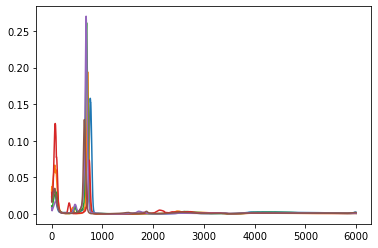

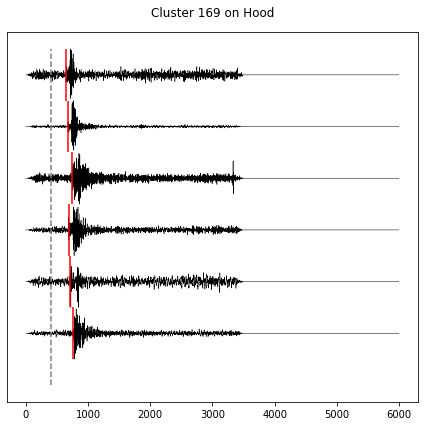

In [11]:
### PULL IN TEMPLATES ###
# cl_trange = trange(max(clid), desc="Finding picktimes for each cluster", leave=True)
cl_trange=range(169,max(clid)+1) #range needs the +1
for cl in cl_trange:
#     print('------') #print a divider
#     print("cluster:",str(cl).zfill(cllen)) #print the cluster ID
    
    temps_w = [] #list of templates waveforms for this cluster
    temps_n = [] #list of template names
    temps_p = [] #list of template picks (list of arrays)
    preds = [] #pred data for looking
    
    stopwatch0=time() #note the time
    
    s_trange = trange(len(v), desc=f"Finding picktimes for each station at cluster {cl}", leave=True) #has a progress bar
#     s_trange = range(0,len(v)) #no progress bar

    rows = [] #list of rows to append to csv
    for s in s_trange: #loop through stations that have a template for this cluster
        net, sta =  v[s].split('.') #add specific network per station
        
        for tt,t in enumerate(all_temps): #go through each template
            if t.split('_')[0]==net and t.split('_')[1]==sta and t.split('_')[-1]==str(cl): #if the template is for this station and cluster
                
                ### PREPARE DATA ###
#                 Trace(all_waves[tt]).plot(); #show before preparation
                wave = all_waves[tt].copy() #create copy
                
                t_tapered = Trace(wave).taper(tape) #make waveform a trace to taper it
                padded_wave = np.hstack((t_tapered.data[:],np.zeros(2480))) #take data from tapered trace and pad end 
                #with zeros so that len(t_trace)=6000 and will fit in the nueral network
                t_trace = Trace(padded_wave,{'sampling_rate':fs}) #make back into a Trace, and set sampling rate
#                 print(len(t_trace))
                
                temps_w.append(t_trace) #append trace
                temps_n.append(t) #append name
                
#                 t_trace.plot(); #plot trace after preparation

    
                ### FIND PICKS! ###

                #picking params
                evt_data = Stream(traces=[t_trace])
                sta_available = [sta]
                list_models = list_models
                twin = len(t_trace)-1


                dt = 1/fs; fs = fs
                nfqs = 5
                nt = 6000; nc = 3
                iend = len(wave)-1 #end of possible pick times
                istart = math.ceil(tape*(len(wave)-1)) #beginning of possible pick times (currently excluding taper)
                
                fq_list = make_LogFq(fqmin, fqmax, dt, nfqs)
                coeff_HP, coeff_LP = rec_filter_coeff(fq_list, dt)
                MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP,                     'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc, 'npoles': 2}

                paras_semblance = {'dt':dt, 'semblance_order':2, 'window_flag':True, 
                                   'semblance_win':0.5, 'weight_flag':'max'}
                
                #find picktimes!
                peaks,smb_pred = apply_mbf(evt_data, sta_available,                 list_models, MBF_paras, paras_semblance, istart, iend) #smb_peak,smb_peak_mbf,
                
                
                print(peaks[0]) # THESE PICKS ARE OFFSET BY ISTART
                
                picks = [i+istart for i in peaks[0]] # ADDED ISTART
                temps_p.append(picks)
                csv_picks=' '.join([str(i/fs)for i in picks]) #formatted for saving in csv
                
                preds.append([smb_pred])
        
                #append picks to csv
                row = [net, sta, cl, t, csv_picks] ### APPEND PICKS NOT PEAKS
                rows.append(row)
                
    if len(temps_n)==0:
        print(f'no templates for cluster {cl}')
        continue

    ### FILTERING PEAKS ###

    one_peak = [] #list of n and y if the template only has one peak/picktime
    for p in temps_p: #for saved picks
        if len(p)==1:
            one_peak.append('y')
        else:
            one_peak.append('n')
            
            
    if one_peak.count('y')/len(one_peak) ==1: #if there is only one peak per template
        #write info to csv as is
        for row in rows:
            with open(csv_name, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(row)
                file.close()

    if one_peak.count('y')/len(one_peak) >=0.5 and one_peak.count('y')/len(one_peak) <1: #if 75% of templates have one peak

        one_p_value = [] #list of peak values when there is only one
        for peaks in temps_p:
            if len(peaks)==1:
                one_p_value.append(peaks[0])
            else:
                continue

        for en,peaks in enumerate(temps_p):
            if len(peaks)>1:
                sums = []#list of sum of differences between possible peaks and the "confirmed" peaks
                for peak in peaks:
                    sums.append(sum([abs(peak-v) for v in one_p_value]))
                closest_peak = peaks[sums.index(min(sums))] #find which peak has the smallest summed distance

            else:
                continue

            rows[en][-1] = str(closest_peak/fs) #update the corresponding row's pick for csv

        #write updated info to csv
        for row in rows:
            with open(csv_name, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(row)
                file.close()


    if one_peak.count('y')/len(one_peak) <0.5:

        for en,peaks in enumerate(temps_p):
            if len(peaks)>1:
                rows[en][-1] = 'UNCERTAIN'

        #write updated info to csv
        for row in rows:
            with open(csv_name, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(row)
                file.close()


    #save smb_pred to h5
    try:
        open(h5_name)
        with h5py.File(h5_name, "a") as f: #append info
            f.create_dataset(f"smb_pred_cl_{cl}", data=np.array(preds))
            f.create_dataset(f"template_names_cl_{cl}", data=temps_n)
    except:
        with h5py.File(h5_name, "w") as f: #create file
            f.create_dataset(f"smb_pred_cl_{cl}", data=np.array(preds))
            f.create_dataset(f"template_names_cl_{cl}", data=temps_n)

    for row in rows: #print info for testing
        print(row)
                    
    ### PLOT ###
    height = len(temps_w)
    fig, ax0 = plt.subplots(figsize=(6,height))

    yscale = 2 #how far to space waveforms from eachother
    wavecolor = 'black'
    for ww, wave in enumerate(temps_w):
        ax0.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color=wavecolor,linewidth=.5)
        for i in temps_p[ww]: 
            plt.vlines(x=i,ymin=(yscale+(yscale*ww))-(0.5*yscale),ymax=(yscale+(yscale*ww))+(0.5*yscale),color='red')
    plt.vlines(x=nlta*fs,ymin=0,ymax=(yscale+(yscale*ww))+(0.5*yscale),color='gray',linestyle='dashed')
    #RED is possible pick times
    #GRAY is the 10 second mark/end noise window for SNR

    ax0.tick_params(axis='y', which='both',left=False,labelleft=False)


    fig.suptitle(f'Cluster {cl} on {volc_list_names[vv]}')
    fig.set_tight_layout(True)
    plt.show()
    plt.close()

  
    break

### Visually Confirming UNCERTAIN peaks

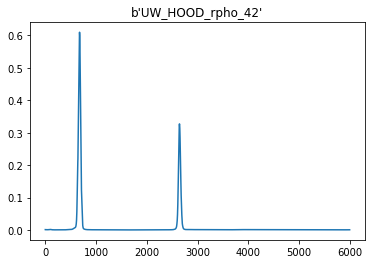

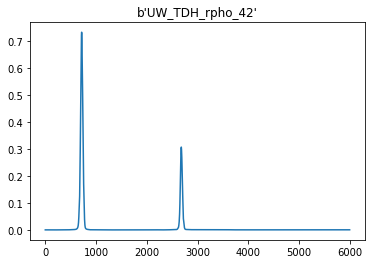

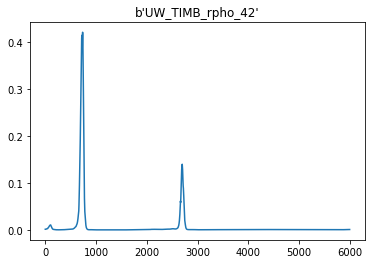

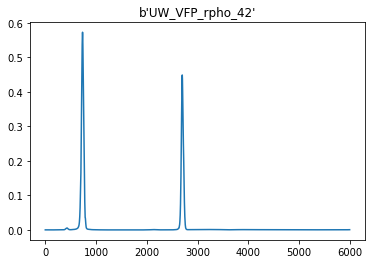

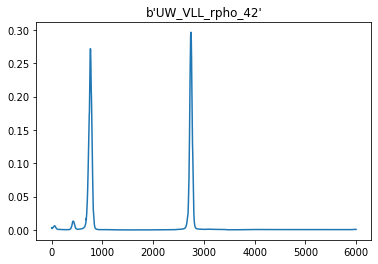

In [72]:
#read h5 file and show smb_pred (probability of pick)
cl = 42

with h5py.File(h5_name, "r") as f:
    h5_t_names = f[f"template_names_cl_{cl}"][()]
    smb = f[f"smb_pred_cl_{cl}"][()]

# print(h5_t_names)

for ss,s in enumerate(smb):
    plt.plot(s[0][0]);
    plt.title(h5_t_names[ss])
    plt.show()
    plt.close()

In [73]:
#find peaks from h5 smb_pred
#same filters as in mbf_elep_func.py
cl_peaks = []

for ss,s in enumerate(smb):
    peaks = signal.find_peaks(s[0][0][istart:iend],distance=5*fs, height=0.03)

    if len(peaks[0]) == 0:
        peaks = signal.find_peaks(s[0][0][istart:iend],distance=5*fs)
        
    poss_picks = [i+istart for i in peaks[0]]
    print([p/fs for p in poss_picks], h5_t_names[ss]) #prints possible picktimes in seconds and template name
    cl_peaks.append(poss_picks)

[16.9, 66.1] b'UW_HOOD_rpho_42'
[17.9, 67.0] b'UW_TDH_rpho_42'
[18.4, 67.475] b'UW_TIMB_rpho_42'
[18.35, 67.475] b'UW_VFP_rpho_42'
[19.125, 68.575] b'UW_VLL_rpho_42'


plotting for each station at cluster 42: 100%|██████████| 16/16 [00:00<00:00, 1905.15it/s]


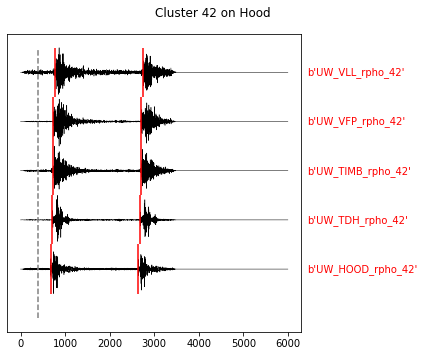

In [74]:
#plot from h5 data
    
    
#find template waveforms
temps_w = [] #list of templates waveforms for this cluster
s_trange = trange(len(v), desc=f"plotting for each station at cluster {cl}", leave=True) #has a progress bar

for s in s_trange: #loop through stations that have a template for this cluster
    net, sta =  v[s].split('.') #add specific network per station

    for tt,t in enumerate(all_temps): #go through each template
        if t.split('_')[0]==net and t.split('_')[1]==sta and t.split('_')[-1]==str(cl): #if the template is for this station and cluster

            ### PREPARE DATA ###
            wave = all_waves[tt].copy() #create copy

            t_tapered = Trace(wave).taper(tape) #make waveform a trace to taper it
            padded_wave = np.hstack((t_tapered.data[:],np.zeros(2480))) #take data from tapered trace and pad end 
            #with zeros so that len(t_trace)=6000 and will fit in the nueral network
            t_trace = Trace(padded_wave,{'sampling_rate':fs}) #make back into a Trace, and set sampling rate

            temps_w.append(t_trace) #append trace
            temps_n.append(t)


#plot
height = len(temps_w)
fig, ax0 = plt.subplots(figsize=(6,height))

yscale = 2 #how far to space waveforms from eachother
wavecolor = 'black'
for ww, wave in enumerate(temps_w):
    ax0.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color=wavecolor,linewidth=.5)
    for i in cl_peaks[ww]: 
        plt.vlines(x=i,ymin=(yscale+(yscale*ww))-(0.5*yscale),ymax=(yscale+(yscale*ww))+(0.5*yscale),color='red')
        
for line, name in zip(ax0.lines, h5_t_names): #label each waveform with the cluster id
    y = line.get_ydata()[-1] #find the y value where the line ends
    ax0.annotate(name, xy=(1,y), xytext=(6,0), color='red', 
                xycoords = ax0.get_yaxis_transform(), textcoords="offset points",
                size=10, va="center")
        
        
plt.vlines(x=nlta*fs,ymin=0,ymax=(yscale+(yscale*ww))+(0.5*yscale),color='gray',linestyle='dashed')
#RED is possible pick times
#GRAY is the 10 second mark/end noise window for SNR

ax0.tick_params(axis='y', which='both',left=False,labelleft=False)


fig.suptitle(f'Cluster {cl} on {volc_list_names[vv]}')
fig.set_tight_layout(True)
plt.show()
plt.close()

---

Compare to ComCat

In [ ]:
cl = 11 #51 is a cluster on hood with no matches
url = f'https://assets.pnsn.org/red/hood/clusters/{cl}.html'

In [ ]:
r = requests.get(url)

matches = str(r.content.splitlines()[20]).split('Potential local match:')[1:]

c_times = []
c_lats = []
c_lons = []
if len(matches)>0:
    for m in matches:
        m_feats = m.split(' ')
        m_time = m_feats[1]
        c_times.append(m_time)
        m_lat = float(m_feats[2][1:-1])
        c_lats.append(m_lat)
        m_lon = float(m_feats[3][:-1])
        c_lons.append(m_lon)
        print(f'TIME {m_time} LAT {m_lat} LON {m_lon}')

else:
    print('no ComCat matches')
    
avg_c_lat = np.average(c_lats)
avg_c_lon = np.average(c_lons)
print(f'Average ComCat Location lat {avg_c_lat} lon {avg_c_lon}')

In [ ]:
# plot ComCat and my locations to compare